<a href="https://colab.research.google.com/github/FrancescoMonaco/LFN_Project/blob/francesco_branch/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval


In [16]:
!pip install nilearn
!pip install plotly

In [17]:
from nilearn import datasets, plotting
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

# Loading the functional datasets
data = datasets.fetch_adhd(n_subjects=1)


Dataset created in /root/nilearn_data/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.



Dataset created in /root/nilearn_data/adhd



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz..... done.


Downloaded 18833408 of 44414948 bytes (42.4%,    1.4s remaining) ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz..... done.


# MRI to Graph

In [10]:
from nilearn.maskers import NiftiMapsMasker

masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

func_filename = data.func[0]
confounds_filename = data.confounds[0]
time_series = masker.fit_transform(data.func[0], confounds=data.confounds)

[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/cache_mixin.py:241: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


[Memory]0.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


[GraphicalLassoCV] Done refinement  1 out of 4:   3s
[GraphicalLassoCV] Done refinement  2 out of 4:  14s
[GraphicalLassoCV] Done refinement  3 out of 4:  30s
[GraphicalLassoCV] Done refinement  4 out of 4:  47s


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:233: RuntimeWarning:

invalid value encountered in subtract



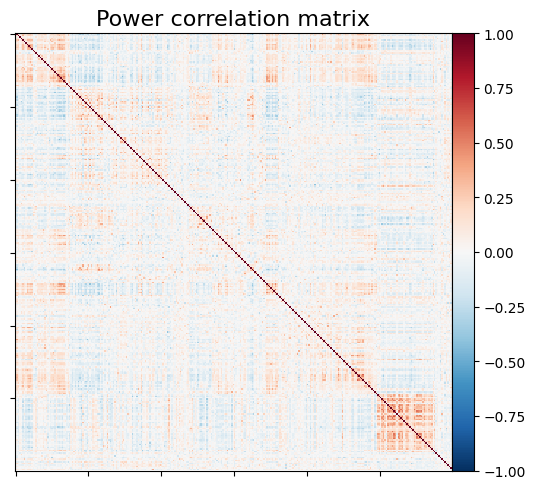

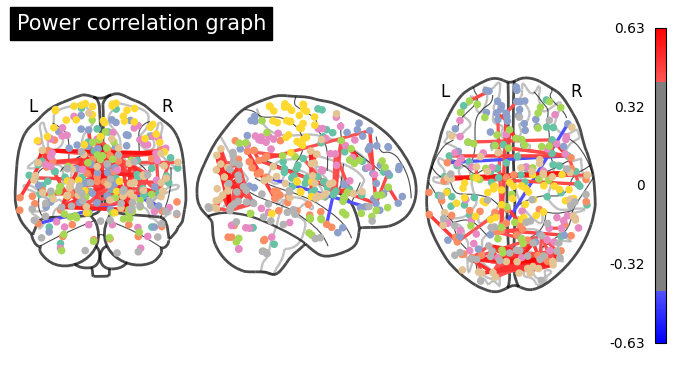

In [38]:
from nilearn.maskers import NiftiSpheresMasker

power = datasets.fetch_coords_seitzman_2018(legacy_format=False)
coords = np.vstack((power.rois["x"], power.rois["y"], power.rois["z"])).T
spheres_masker = NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=6,
    radius=3.0,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
)

timeseries = spheres_masker.fit_transform(
    func_filename, confounds=confounds_filename
)

try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

covariance_estimator = GraphicalLassoCV(cv=3, verbose=1)

covariance_estimator.fit(timeseries)
matrix = covariance_estimator.covariance_
plotting.plot_matrix(
    matrix,
    vmin=-1.0,
    vmax=1.0,
    colorbar=True,
    title="Power correlation matrix",
)

# Tweak edge_threshold to keep only the strongest connections.
plotting.plot_connectome(
    matrix,
    coords,
    title="Power correlation graph",
    edge_threshold="99.8%",
    node_size=20,
    colorbar=True,
)

In [48]:
threshold = 0.2 # @param {type:"slider", min:0, max:1, step:0.05}
power_correlation_matrix = matrix
G = nx.Graph()
n = power_correlation_matrix.shape[0]  # Number of brain regions

for i in range(n):
    for j in range(i + 1, n):
        if power_correlation_matrix[i, j] >= threshold:
            G.add_edge(i, j)


In [49]:
pos = nx.spring_layout(G)
node_degrees = dict(G.degree())


# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure with size proportional to degree
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(x=[x], y=[y], mode="markers", marker=dict(size=2 * node_degrees[node], opacity=0.7), name=str(node)))

# Add edges to the figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1)))

# Customize the figure further as needed

# Show the interactive plot
fig.show()


In [50]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(node_degrees.values()) / num_nodes

# Print the results
print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Average Degree:", average_degree)

Number of Nodes: 285
Number of Edges: 1485
Average Degree: 10.421052631578947
